# Deep Learning Project - Gesture Recognition

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

#### Gesture Corresponding -> Action
* Thumbs Up	-> Increase the volume  
* Thumbs Down	-> Decrease the volume  
* Left Swipe	-> 'Jump' backwards 10 seconds  
* Right Swipe	-> 'Jump' forward 10 seconds  
* Stop	    -> Pause the movie  
* Each video is a sequence of 30 frames (or images).  



## Dataset
Below code will extract the data from google drive and unzips it to specified directory.

It consist of 663 videos for training, there are 30 frames for each video. For validation there are 100 videos of 30 frames each to measure the accuracy of the solution.

In [4]:
#Import the libraries
import zipfile
import os

In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Extracting Images from zip file to another directory
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Project_data.zip', 'r') 
zip_ref.extractall('/content/Gesture_Recognition_Project/Extracted_Data') 
zip_ref.close()

In [ ]:
#copying data to runtime to run faster

In [12]:
# setting the path for extracted directory

project_folder='/content/Gesture_Recognition_Project/Extracted_Data/Project_data'

In [ ]:
# Installing older version of scipy (1.1.0) as they have discontinued the support of imread since scipy 1.1.1

In [4]:
!pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import packages and libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [ ]:
# set random seed that each run produces all most same results

# np.random.seed(30)
# import random as rn
# rn.seed(30)
# from keras import backend as K
# import tensorflow as tf
# tf.random.set_seed(30)

In [5]:
# import libraries for image manipulation

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [11]:
# import tensorflow and keras libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

## Model Builder class

##### Building a class with which we will perform actions mentioned below:
1. intitialise paths
2. initialise image properties
3. set hyperparameters
4. generator method 
5. data fetch per batch
6. model trainer method

We will reuse the methods in class to run the model with different hyperparameters.

Generator Method:
This is one of the most important part of the code, it preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames.

In [17]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # method to initialise the paths and number of sequences

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
    # initialise image properties

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # Set hyperparameters

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # Define generator function

    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size  # get whole number of batches
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size   # get balance number in the last batch
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    # get one batch of data

    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size

        # define the matrix for the image data and the label data

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 

            # get list of the images in the video directory

            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                # read an image
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                # resize image
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                # normalize image data
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                # create new images by augmentation

                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                               
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        # Concatenate augmented images

        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    # method to train a model
    
    def train_model(self, model, augment_data=False):

        # create the train and validation generator

        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # we will save best model information in *.h5 file

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # create model check point to save model when validation less goes down

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # set number of steps per epochs so that correct number batch generator calls are made

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
        # fit the model
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Model Building Process
Creating different models as the requirment, the main objective is to design the network in such a way that the model is able to give good accuracy with the least number of parameters.

#### Starting with a simple network to test implementation

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 15, 80, 80, 32)   

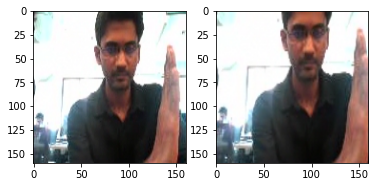

In [ ]:
# Sample Cropping
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

## Approach

We will use following three deep learning architectures to come up with an optimum model
<ol>
    <li>3D Convolutional layers model.</li>
    <li>2D Convolutional layers for feature identification + RNN layers (LSTM + GRU) for gesture recognition.</li>
    <li>Use transfer learning with a pre-builit model such as MobileNet for feature detection + RNN layers (LSTM + GRU) for gesture recognition.</li>
</ol>

#### Experiemnts 
trying to understand how the image resolution and number of images, batch size affect the training time

In [ ]:
# 160, 160, 16, 30
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6043 - categorical_accuracy: 0.4027
Epoch 1: val_loss improved from inf to 3.04552, saving model to model_init_2022-08-1311_01_48.628712/model-00001-1.60434-0.40271-3.04552-0.16000.h5
23/23 [==============================] - 62s 3s/step - loss: 1.6043 - categorical_accuracy: 0.4027 - val_loss: 3.0455 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.0876 - categorical_accuracy: 0.5535
Epoch 2: val_loss did not improve from 3.04552
23/23 [==============================] - 53s 2s/step - loss: 1.0876 - categorical_accuracy: 0.5535 - val_loss: 7.0016 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.9700 - categorical_accuracy: 0.6094
Epoch 3: val_loss did not improve from 3.04552
23/23 [==============================] - 52s 2s/step - loss: 0.9700 - categorical_accurac

In [ ]:
### Facing runtime issues with google colab while runnning above code

In [ ]:
# 100, 100, 16, 30
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.7212 - categorical_accuracy: 0.3922
Epoch 1: val_loss improved from inf to 2.01839, saving model to model_init_2022-08-1311_05_50.981355/model-00001-1.72123-0.39216-2.01839-0.21000.h5
23/23 [==============================] - 47s 2s/step - loss: 1.7212 - categorical_accuracy: 0.3922 - val_loss: 2.0184 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.2001 - categorical_accuracy: 0.5354
Epoch 2: val_loss did not improve from 2.01839
23/23 [==============================] - 46s 2s/step - loss: 1.2001 - categorical_accuracy: 0.5354 - val_loss: 3.6195 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.9763 - categorical_accuracy: 0.6214
Epoch 3: val_loss did not improve from 2.01839
23/23 [==============================] - 45s 2s/step - loss: 0.9763 - categorical_accuracy

In [ ]:
# 100, 100, 16, 60
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.7981 - categorical_accuracy: 0.3514
Epoch 1: val_loss improved from inf to 1.61561, saving model to model_init_2022-08-1311_11_38.952546/model-00001-1.79814-0.35143-1.61561-0.16000.h5
12/12 [==============================] - 49s 4s/step - loss: 1.7981 - categorical_accuracy: 0.3514 - val_loss: 1.6156 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
11/12 [==========================>...] - ETA: 3s - loss: 1.2334 - categorical_accuracy: 0.5015
Epoch 2: val_loss did not improve from 1.61561
12/12 [==============================] - 45s 4s/step - loss: 1.2380 - categorical_accuracy: 0.5023 - val_loss: 2.6453 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [ ]:
# 160, 160, 16, 15
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6258 - categorical_accuracy: 0.4012
Epoch 1: val_loss improved from inf to 3.54728, saving model to model_init_2022-08-1311_14_05.649034/model-00001-1.62581-0.40121-3.54728-0.23000.h5
45/45 [==============================] - 52s 1s/step - loss: 1.6258 - categorical_accuracy: 0.4012 - val_loss: 3.5473 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1722 - categorical_accuracy: 0.5339
Epoch 2: val_loss did not improve from 3.54728
45/45 [==============================] - 51s 1s/step - loss: 1.1722 - categorical_accuracy: 0.5339 - val_loss: 3.6397 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [ ]:
# 100, 100, 16, 15
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.7016 - categorical_accuracy: 0.3937
Epoch 1: val_loss improved from inf to 4.79564, saving model to model_init_2022-08-1311_22_39.777402/model-00001-1.70162-0.39367-4.79564-0.21000.h5
45/45 [==============================] - 47s 1s/step - loss: 1.7016 - categorical_accuracy: 0.3937 - val_loss: 4.7956 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2417 - categorical_accuracy: 0.5158
Epoch 2: val_loss did not improve from 4.79564
45/45 [==============================] - 46s 1s/step - loss: 1.2417 - categorical_accuracy: 0.5158 - val_loss: 7.6838 - val_categorical_accuracy: 0.1900 - lr: 0.0010


### Conclusion of Experiments
- As we see from the above experiments image resolution and number of frames in sequence have a direct impact on training time than batch_size

- From the above observations, we fixed the <em>batch size between 15 and 40</em>. We changed the <em>resolution and number of image per sequence</em> based on the device memory constraints (100, 120). 
- Models are designed such that their memory foot print is less than 50 MB

## Model 1
- Batch Size: 40
- Epoch: 15

In [20]:
## Plotting
#Function to plot validation and training metrics

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
# derive a new model class from abstract model class
# this will have the new model architecture

class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# create the model and set the hyperparamters

conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_45 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
# train the model

print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5563 - categorical_accuracy: 0.4042
Epoch 1: saving model to model_init_2022-08-1312_05_20.251316/model-00001-1.55631-0.40422-1.54030-0.23000.h5
17/17 [==============================] - 81s 5s/step - loss: 1.5563 - categorical_accuracy: 0.4042 - val_loss: 1.5403 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1198 - categorical_accuracy: 0.5505
Epoch 2: saving model to model_init_2022-08-1312_05_20.251316/model-00002-1.11977-0.55053-4.42296-0.20000.h5
17/17 [==============================] - 86s 5s/step - loss: 1.1198 - categorical_accuracy: 0.5505 - val_loss: 4.4230 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7921 - categorical_accuracy: 0.6938
Epoch 3: saving model to model_init_2022-08-1312_05_20.251316/model-00003-0.79209-0.69382-5.60791-0.13000.h5
1

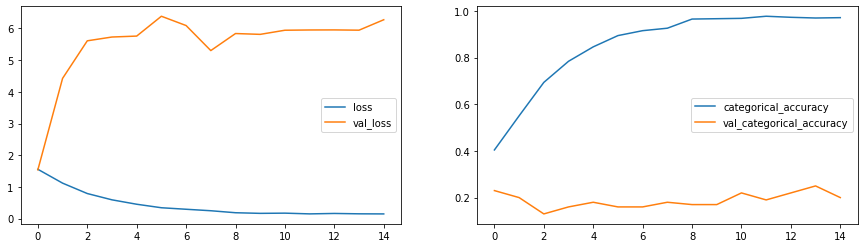

In [ ]:
# Plot the training and validation metrics

plot(history_model1)

## Observations: Model1
- Models shows high training accuracy and low validation accuracy
- Model is overfitting. So we will try to do data augumentation

## Model 2 - Augementation Implementation

We are trying to handle the overfitting with augemetation and more epochs
We also increased dropout from 0.25 to 0.5 to see if helps in underfitting

 - Data Augmentation - to address overfitting
 - Batch Size 20
 - Epoch from 15 to 25
 - Dropout from 0.5 to 0.25

In [ ]:
 # create the model and set hyperparameters

conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25) # no. of epochs changed to 25
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5) # dropout is 0.5
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [ ]:
# training the model

print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9620 - categorical_accuracy: 0.3808
Epoch 1: saving model to model_init_2022-08-1314_26_46.295002/model-00001-1.96198-0.38084-5.01717-0.23000.h5
34/34 [==============================] - 129s 4s/step - loss: 1.9620 - categorical_accuracy: 0.3808 - val_loss: 5.0172 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3751 - categorical_accuracy: 0.5204
Epoch 2: saving model to model_init_2022-08-1314_26_46.295002/model-00002-1.37508-0.52036-8.50359-0.14000.h5
34/34 [==============================] - 136s 4s/step - loss: 1.3751 - categorical_accuracy: 0.5204 - val_loss: 8.5036 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1773 - categorical_accuracy: 0.5799
Epoch 3: saving model to model_init_2022-08-1314_26_46.295002/model-00003-1.17733-0.57994-6.22655-0.21000.h5

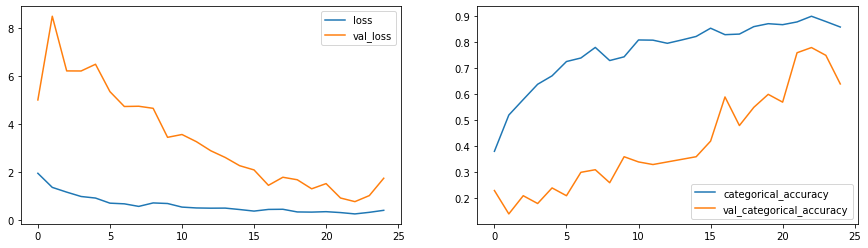

In [ ]:
# Plot the training and validation metrics

plot(history_model2)

### Observations of Model2

- Model is not overfitting and we get a good training and validation accuracy of around 65%. 
- Next we will try some more methods, 
  - reduce the filter size
  - reduce image resolution
- Since we see oscillations in loss, let's try lowering the learning rate to 0.0002

## Model 3: Reduced image resoltuion and filter size
-  Reduce filter size to (2,2,2)
-  Image resoultion reduced to 120 x  120

In [11]:
# derive a new model with new architecture with learning rate 0.0002

class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
# defining hyperparameters

conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)  # define reduced image size of 120 X 120
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)  # reduce filter size to (2,2,2)
conv_3d3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

In [13]:
# train the model with augmentation

print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.2108 - categorical_accuracy: 0.3062
Epoch 1: saving model to model_init_2022-08-1404_10_28.664497/model-00001-2.21084-0.30618-1.79620-0.16000.h5
23/23 [==============================] - 109s 4s/step - loss: 2.2108 - categorical_accuracy: 0.3062 - val_loss: 1.7962 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4952 - categorical_accuracy: 0.4796
Epoch 2: saving model to model_init_2022-08-1404_10_28.664497/model-00002-1.49518-0.47964-2.68216-0.16000.h5
23/23 [==============================] - 92s 4s/step - loss: 1.4952 - categorical_accuracy: 0.4796 - val_loss: 2.6822 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.4321 - categorical_accuracy: 0.5106
Epoch 3: saving model to model_init_2022-08-1404_10_28.664497/model-00003-1.43212-0.51056-3.72433-0.1

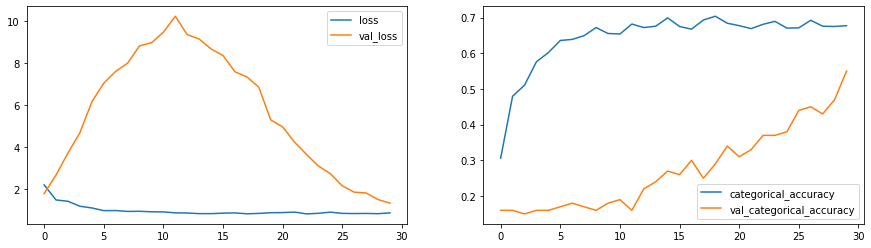

In [16]:
# Plot training and validation metrics

plot(history_model3)

#### Observations of Model 3

- Model has not displayed better validation accuracy compared to earlier model.

## Model 4 - Adding more layers - I am trying to see if model accuracy increases if we add more layers

- 8 CNN layers
- Number of epochs increased to 30 to gain more accuracy
- Filter size (3,3,3)

In [17]:
# define new model architecure now with 8 CNN layers

class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        # CNN layer 1
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 2
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 3
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 4
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 5
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 6
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        # CNN layer 7
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # CNN layer 8
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
# define model hyper paramters

conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)  # increased no. of neurons in dense layer
conv_3d4_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_5 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_7 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                      

In [19]:
# train the model

print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0080 - categorical_accuracy: 0.3439
Epoch 1: saving model to model_init_2022-08-1404_54_24.410591/model-00001-2.00804-0.34389-1.67880-0.35000.h5
34/34 [==============================] - 92s 3s/step - loss: 2.0080 - categorical_accuracy: 0.3439 - val_loss: 1.6788 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6600 - categorical_accuracy: 0.4186
Epoch 2: saving model to model_init_2022-08-1404_54_24.410591/model-00002-1.65996-0.41855-2.86036-0.14000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.6600 - categorical_accuracy: 0.4186 - val_loss: 2.8604 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.5578 - categorical_accuracy: 0.4729
Epoch 3: saving model to model_init_2022-08-1404_54_24.410591/model-00003-1.55776-0.47285-6.50809-0.19000.h5
3

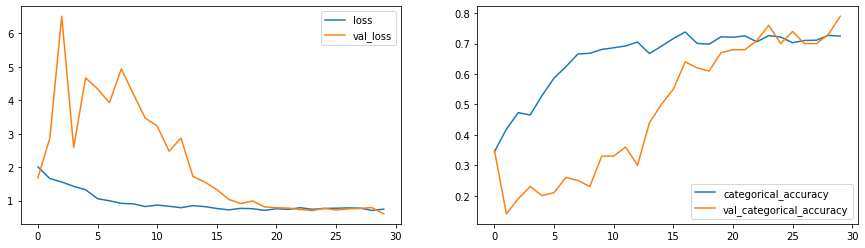

In [20]:
### plot the training and validation metrics

plot(history_model4)

### Observations

- With more layers we see drastic performance improvement. We get validation accuracy of 79% 

# Model 5 - Low memory footprint model
- Reducing the number of parameters
- Reducing the no. of neurons
- Image 120 * 120
- batch_size: 20
- epochs: 25
- dropouts:0.25
- learning rate: 0.0002

In [22]:
# Building model with reduced parameters

class ModelConv3D5(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d5 = ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120, image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)  # reduced epoch
conv_3d5_model=conv_3d5.define_model(dense_neurons=64,dropout=0.25) # reduced no. of neurons
conv_3d5_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 32)    

In [28]:
#training
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8052 - categorical_accuracy: 0.3130
Epoch 1: saving model to model_init_2022-08-1406_58_10.418757/model-00001-1.80518-0.31297-1.90456-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.8052 - categorical_accuracy: 0.3130 - val_loss: 1.9046 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2483 - categorical_accuracy: 0.5113
Epoch 2: saving model to model_init_2022-08-1406_58_10.418757/model-00002-1.24834-0.51131-3.05461-0.15000.h5
34/34 [==============================] - 83s 3s/step - loss: 1.2483 - categorical_accuracy: 0.5113 - val_loss: 3.0546 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0568 - categorical_accuracy: 0.5822
Epoch 3: saving model to model_init_2022-08-1406_58_10.418757/model-00003-1.05679-0.58220-4.36384-0.160

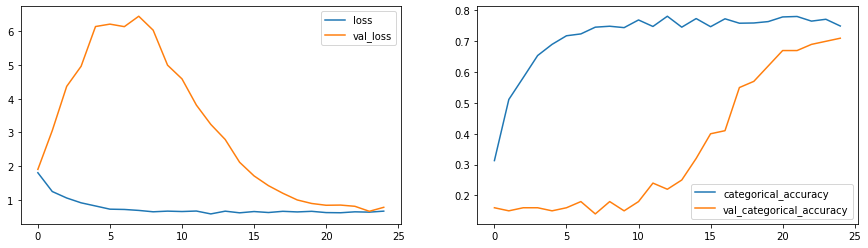

In [29]:
plot(history_model5)

### Observations

- For the above low memory foot print model the best validation accuracy of 71%
- We can revise the parameters to check performance

# Model 6: CNN- LSTM Model

- Five CNN 2D layers.
- One LSTM layer of 128 cells
- 25 epochs


In [18]:
# LSTM-CNN the model

class LSTMCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
# Define LSTM CNN joint model

rnn_cnn1=LSTMCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=25) 
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [9]:
# train th emodel

print("Total Params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4466 - categorical_accuracy: 0.3703
Epoch 1: saving model to model_init_2022-08-1407_47_58.522713/model-00001-1.44662-0.37029-1.82262-0.21000.h5
34/34 [==============================] - 126s 3s/step - loss: 1.4466 - categorical_accuracy: 0.3703 - val_loss: 1.8226 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2395 - categorical_accuracy: 0.4729
Epoch 2: saving model to model_init_2022-08-1407_47_58.522713/model-00002-1.23947-0.47285-2.22248-0.19000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.2395 - categorical_accuracy: 0.4729 - val_loss: 2.2225 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1109 - categorical_accuracy: 0.5415
Epoch 3: saving model to model_init_2022-08-1407_47_58.522713/model-00003-1.11094-0.54148-2.32189-0.20000.h5


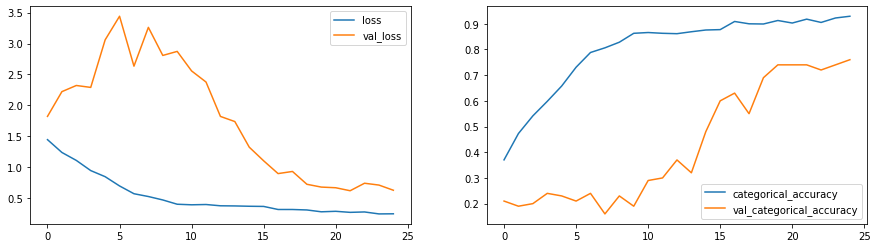

In [12]:
# plot training and validation metrics
plot(history_model6)

### Observations & Conclusions

- For LSTM-CNN model we observed a best validation accuracy of 76% and training accuracy of around 92%.
- As we see overfitting, let us augment the data with a small amount of rotation and with the same model.

#### Augmentated Model

- Augment the above RNN CNN model

In [13]:

class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height)) # rotate pics
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model 7
- Increased Filter size to 3
- Increased image resolution to 160 X 160
- batch size: 20
- epochs: 30
- neurons: 256
- learning rate: 0.0002
- Run with rotated pics in the augmentation

In [14]:
# below class inherit model builder class 

class ModelConv3D7(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
# build the model

conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=160,image_width=160)
conv_3d7.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(filtersize=(2,2,2), dense_neurons=256,dropout=0.5)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  400       
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

In [16]:
# train the model

print("Total Params:", conv_3d7_model.count_params())
history_model7 = conv_3d7.train_model(conv_3d7_model, augment_data=True)

Total Params: 3433781
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1255 - categorical_accuracy: 0.3469
Epoch 1: saving model to model_init_2022-08-1410_06_41.138361/model-00001-2.12555-0.34691-2.41598-0.16000.h5
34/34 [==============================] - 156s 4s/step - loss: 2.1255 - categorical_accuracy: 0.3469 - val_loss: 2.4160 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4854 - categorical_accuracy: 0.5181
Epoch 2: saving model to model_init_2022-08-1410_06_41.138361/model-00002-1.48542-0.51810-4.40982-0.17000.h5
34/34 [==============================] - 135s 4s/step - loss: 1.4854 - categorical_accuracy: 0.5181 - val_loss: 4.4098 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2562 - categorical_accuracy: 0.5724
Epoch 3: saving model to model_init_2022-08-1410_06_41.138361/model-00003-1.25615-0.57240-6.32660-0.

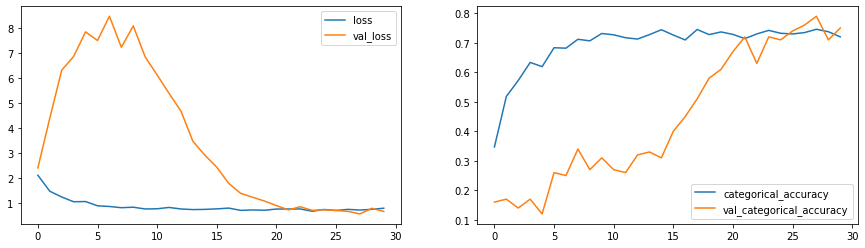

In [21]:
# plot training and validation metrics
plot(history_model7)

### Observations

- Model has given a good accuracy of around 79% for both training and validation.

## Model 8
- Transfer Learning with Mobilnet

In [22]:
# import required libraries

from keras.applications import mobilenet

In [23]:
# define transfer learning model

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [24]:
# build the model

rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)              

In [25]:
# train the model

print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3480 - categorical_accuracy: 0.4223
Epoch 1: saving model to model_init_2022-08-1411_31_48.275874/model-00001-1.34797-0.42232-0.88297-0.71000.h5
133/133 [==============================] - 97s 694ms/step - loss: 1.3480 - categorical_accuracy: 0.4223 - val_loss: 0.8830 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8565 - categorical_accuracy: 0.6787
Epoch 2: saving model to model_init_2022-08-1411_31_48.275874/model-00002-0.85650-0.67873-0.80650-0.66000.h5
133/133 [==============================] - 85s 640ms/step - loss: 0.8565 - categorical_accuracy: 0.6787 - val_loss: 0.8065 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6328 - categorical_accuracy: 0.7685
Epoch 3: saving model to model_init_2022-08-1411_31_48.275874/model-00003-0.63276-0.76848-0.61

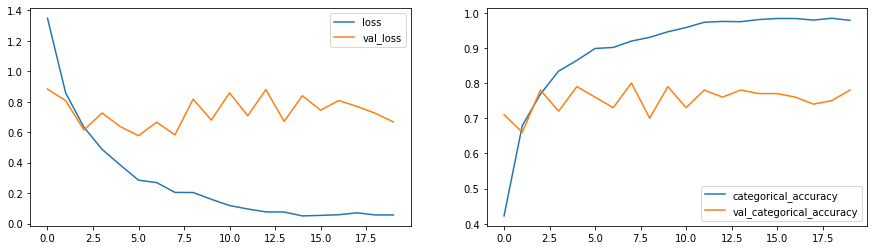

In [27]:
# plot training and validation metrics
plot(history_model18)

### Observations

- Model training accuracy 97% and validation accuracy 78%
- We are not training the mobilenet weights and we see validation accuracy is very poor. 
- Let's train them as well and observe if there is performance improvement.

## Model 9: GRU CNN
- Transfer Learning with GRU and training all weights
- Cells: 64
- epochs: 20
- batch size: 5
- image size:120*120
- 

In [28]:
# import required libraries

from keras.applications import mobilenet

In [30]:
# define the model

from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
# build the model

rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [33]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model9=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2462 - categorical_accuracy: 0.4766
Epoch 1: saving model to model_init_2022-08-1412_09_27.633077/model-00001-1.24621-0.47662-0.72145-0.75000.h5
133/133 [==============================] - 95s 714ms/step - loss: 1.2462 - categorical_accuracy: 0.4766 - val_loss: 0.7214 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6638 - categorical_accuracy: 0.7179
Epoch 2: saving model to model_init_2022-08-1412_09_27.633077/model-00002-0.66379-0.71795-0.43724-0.77000.h5
133/133 [==============================] - 93s 704ms/step - loss: 0.6638 - categorical_accuracy: 0.7179 - val_loss: 0.4372 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5100 - categorical_accuracy: 0.7979
Epoch 3: saving model to model_init_2022-08-1412_09_27.633077/model-00003-0.50997-0.79789-0.41

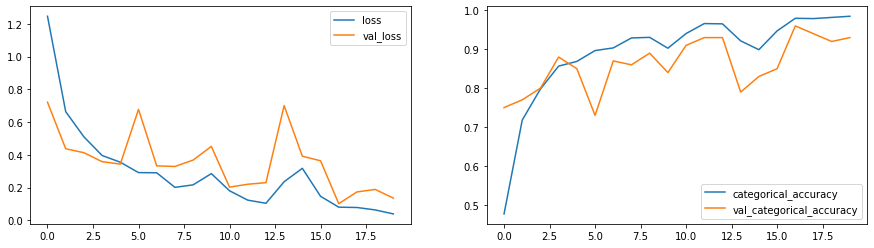

In [34]:
# plotting the trainign and validation metrics
plot(history_model9)

### Observations
- This has the best performance
- It shows a training accuracy of **_98.5%_** and a validation accuracy of **_93%_**

## Conclusions

<ol>
<li>
We started building our model with exercise, experiment on getting the optimal parameters like image resolution, frame size and batch sizes.
</li>
<li>We have tried different models starting with a base model of CNN only and slowly building up by including RNN layers. We have also included transfer learning to check its performance in gesture recognition.</li>
<li>In all models, we checked different parameters and tested their performance on the available data. The CNN 2D models were generally overfitting with high training accuracy of around 90% and low validation accuracy of around 71% while a CNN 3D model gave around 79% with no overfitting. </li>
<li>CNNs with RNN proved better than only CNN models. Both CNN 2D and CNN 3D models with RNN showed similar accuracies.</li>
<li><em>Transfer Learning.  </em>Lastely We trained the models using transfer learning from MobileNet with GRU cells without and with training of transfer learning weights. The model with trained transfer learning weights provided the best accuracy. We achieved a <em>training accuracy</em> of <em><strong>98.5%</strong></em> and a <em>validation accuracy</em> of <em><strong>93%</strong></em>.</li>
</ol>

## Learnings
<ol>
<li>As seen in this study, transfer learning has proved to be better than any other models including complex ones with LSTM and GRU with CNN. Any machine learning model should be quickly deployed. So, using available resources like transfer learning is important</li>
<li>In the absence of a suitable transfer learning model, we should explore more options and layers of the different available CNN and RNN models including various activation functions and residual network options.</li>
</ol>

# Loading model and Testing

In [36]:
# laoding the h5 file stored
import time
from keras.models import load_model
model = load_model('/content/model_init_2022-08-1412_09_27.633077/model-00020-0.03938-0.98492-0.13614-0.93000.h5')

In [37]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [38]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [39]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 2 0 3 4]
